In [111]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

import json
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.datasets import load_boston
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from datetime import datetime
from scipy import stats
import torch.utils.data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [112]:
train_csv = pd.read_csv("Train.csv", keep_default_na=False)
test_csv = pd.read_csv("Test.csv", keep_default_na=False)

# train = train[0:30]
print(train_csv.dtypes)
#print(train_csv['traffic_volume'])

date_time               object
is_holiday              object
air_pollution_index      int64
humidity                 int64
wind_speed               int64
wind_direction           int64
visibility_in_miles      int64
dew_point                int64
temperature            float64
rain_p_h               float64
snow_p_h               float64
clouds_all               int64
weather_type            object
weather_description     object
traffic_volume           int64
dtype: object


In [113]:
test_csv.shape

(14454, 14)

In [114]:
train_csv.shape

(33750, 15)

In [115]:
def convertAbsoluteTime(x):
    if x != "":
        datet = datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
        return datet.timestamp()
    return x

def convertDayOfWeek(x):
    if x != "":
        datet = datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
        return datet.timetuple().tm_wday
    return x

def convertDayOfYear(x):
    if x != "":
        datet = datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
        return datet.timetuple().tm_yday
    return x

def convertDayOfMonth(x):
    if x != "":
        datet = datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
        return datet.timetuple().tm_mday
    return x

def convertHourOfYear(x):
    if x != "":
        datet = datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
        return datet.timetuple().tm_hour
    return x

In [116]:
def preprocess_data(dataset):
    #dataset['Power'] = dataset["Power"].replace("bhp", "", regex=True).replace("null", "", regex=True)
    #dataset['Power'] = pd.to_numeric(dataset["Power"].str.strip())
    #dataset['Engine'] = dataset["Engine"].replace("CC", "", regex=True)
    #dataset['Engine'] = pd.to_numeric(dataset["Engine"].str.strip())
    dataset['absolute_time'] = dataset["date_time"].apply(convertAbsoluteTime)
    dataset['day_of_week'] = dataset["date_time"].apply(convertDayOfWeek)
    dataset['day_of_year'] = dataset["date_time"].apply(convertDayOfYear)
    dataset['hour_of_day'] = dataset["date_time"].apply(convertHourOfYear)
    dataset['day_of_month'] = dataset["date_time"].apply(convertDayOfMonth)
    
    #dataset['Mileage'] = pd.to_numeric(dataset["Mileage"])
    #dataset['New_Price'] = dataset["New_Price"].apply(convertKgtoL)
    #dataset['New_Price'] = pd.to_numeric(dataset["New_Price"])
   
    dataset = dataset.replace('NaN', '')
    dataset = dataset.replace('0', '')
    dataset['weather_description'] = dataset["weather_description"].replace(" ", "_", regex=True).str.lower()
    dataset['is_holiday'] = dataset["is_holiday"].replace(" ", "_", regex=True).str.lower()    

    for col in list(dataset.columns):
        if dataset[col].dtype == np.float64 or dataset[col].dtype == np.int64:
            dataset[col] = pd.to_numeric(dataset[col])
            #dataset[col] = dataset[col].mask(dataset[col]<=0)
    
    dataset.sort_values("date_time", inplace=True)
    #dataset.drop_duplicates(subset=['date_time'], keep = False, inplace = True) 
    dataset = dataset.drop(['date_time'],axis=1)
    dataset = dataset.drop(['weather_type'],axis=1)
    #dataset = dataset.drop(['Year'],axis=1)
    return dataset

In [117]:
train = preprocess_data(train_csv)
test = preprocess_data(test_csv)

display(train.head())
#train.columns

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_description,traffic_volume,absolute_time,day_of_week,day_of_year,hour_of_day,day_of_month
0,none,121,89,2,329,1,1,288.28,0.0,0.0,40,scattered_clouds,5545,1.349149e+09,1,276,9,2
1,none,178,67,3,330,1,1,289.36,0.0,0.0,75,broken_clouds,4516,1.349152e+09,1,276,10,2
2,none,113,66,3,329,2,2,289.58,0.0,0.0,90,overcast_clouds,4767,1.349156e+09,1,276,11,2
3,none,20,66,3,329,5,5,290.13,0.0,0.0,90,overcast_clouds,5026,1.349159e+09,1,276,12,2
4,none,281,65,3,329,7,7,291.14,0.0,0.0,75,broken_clouds,4918,1.349163e+09,1,276,13,2


In [118]:
"""
for c in ["weather_description", "is_holiday"]:
    lbl = LabelEncoder() 
    lbl.fit(list(np.concatenate((train[c].values, test[c].values), axis=None))) 
    train[c] = lbl.transform(list(train[c].values))
    test[c] = lbl.transform(list(test[c].values))
"""

'\nfor c in ["weather_description", "is_holiday"]:\n    lbl = LabelEncoder() \n    lbl.fit(list(np.concatenate((train[c].values, test[c].values), axis=None))) \n    train[c] = lbl.transform(list(train[c].values))\n    test[c] = lbl.transform(list(test[c].values))\n'

In [119]:
train.shape

(33750, 18)

In [120]:
train['traffic_volume'].describe()

count    33750.000000
mean      3240.118163
std       1991.487289
min          0.000000
25%       1165.250000
50%       3335.000000
75%       4926.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [121]:
print("Skewness: %f" % train['traffic_volume'].skew())
print("Kurtosis: %f" % train['traffic_volume'].kurt())

Skewness: -0.071139
Kurtosis: -1.315953


In [122]:
train.dtypes

is_holiday              object
air_pollution_index      int64
humidity                 int64
wind_speed               int64
wind_direction           int64
visibility_in_miles      int64
dew_point                int64
temperature            float64
rain_p_h               float64
snow_p_h               float64
clouds_all               int64
weather_description     object
traffic_volume           int64
absolute_time          float64
day_of_week              int64
day_of_year              int64
hour_of_day              int64
day_of_month             int64
dtype: object

In [123]:
train.columns

Index(['is_holiday', 'air_pollution_index', 'humidity', 'wind_speed',
       'wind_direction', 'visibility_in_miles', 'dew_point', 'temperature',
       'rain_p_h', 'snow_p_h', 'clouds_all', 'weather_description',
       'traffic_volume', 'absolute_time', 'day_of_week', 'day_of_year',
       'hour_of_day', 'day_of_month'],
      dtype='object')

In [124]:
#combined_set = pd.concat([train, test], axis=0, ignore_index=True)

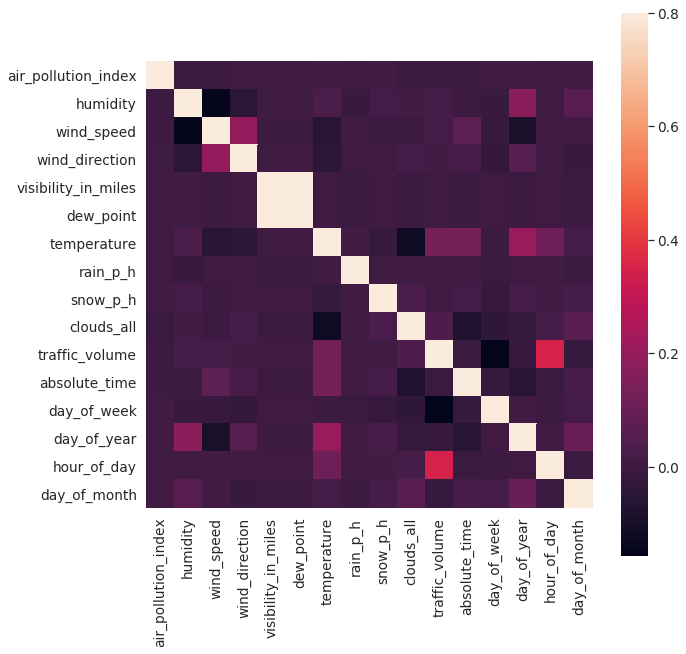

In [125]:
corcolm = ['is_holiday', 'air_pollution_index', 'humidity', 'wind_speed',
       'visibility_in_miles', 'temperature', 'clouds_all', 'weather_description', 'traffic_volume'];

linearcol = ["traffic_volume", "hour_of_day", "temperature", "rain_p_h"]
linearcolbias = ["hour_of_day", "temperature", "rain_p_h"]
textcol = ["weather_description", "is_holiday"]

#correlation matrix
#corrmat = train[corcolm].corr()
corrmat = train.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True);


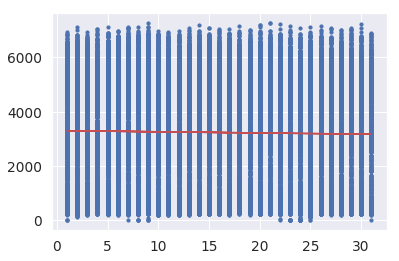

In [126]:
#x_train = train.drop('traffic_volume',axis = 1)
x = np.array(train.day_of_month).reshape((33750,1))
y = np.array(train.traffic_volume).reshape((33750,1))

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

plt.scatter(x, y, s=10)
plt.plot(x, y_pred, color='r')
plt.show()

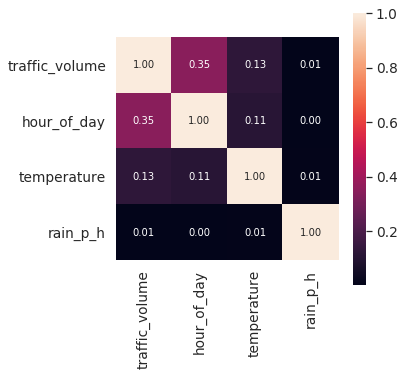

In [127]:
#corrmat = train[linearcol].corr()
#saleprice correlation matrix
k = 6 #number of variables for heatmap
cols = train[linearcol].corr().index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(5, 5))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [128]:
#combined_set = combined_set[corcolm]
#train = train[corcolm]

total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
day_of_month,0,0.0
hour_of_day,0,0.0
air_pollution_index,0,0.0
humidity,0,0.0
wind_speed,0,0.0
wind_direction,0,0.0
visibility_in_miles,0,0.0
dew_point,0,0.0
temperature,0,0.0
rain_p_h,0,0.0


In [129]:
#train = train.interpolate(method ='linear', limit_direction ='both')

In [130]:
col_train_num = list(linearcol)

col_train_num_bias = list(linearcol)
col_train_num_bias.remove('traffic_volume')

train = train[col_train_num]
test = test[col_train_num_bias]

mat_train = np.matrix(train)
mat_test  = np.matrix(test)
mat_new = np.matrix(train.drop('traffic_volume',axis = 1))
mat_y = np.array(train.traffic_volume).reshape((33750,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

# trimed_test.to_csv("output_final_3.csv")
train_set = pd.DataFrame(prepro.transform(train),columns = col_train_num)

# test = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

test_set  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_num_bias)

display(train_set.head())

,traffic_volume,hour_of_day,temperature,rain_p_h
0,0.761676,0.391304,0.935245,0.0
1,0.620330,0.434783,0.938749,0.0
2,0.654808,0.478261,0.939463,0.0
3,0.690385,0.521739,0.941247,0.0
4,0.675549,0.565217,0.944524,0.0


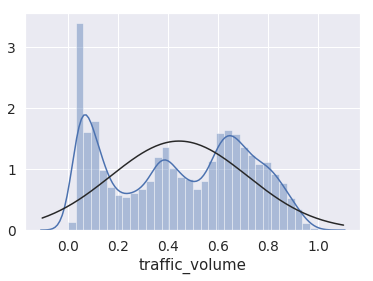

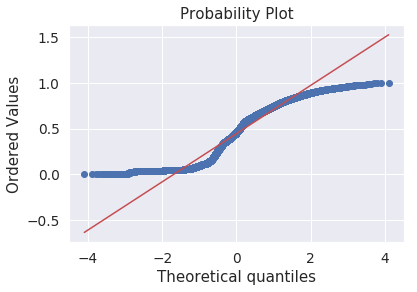

In [131]:
#train['traffic_volume'] = np.sqrt(train['traffic_volume'])
#print(train['traffic_volume'])
#std = MinMaxScaler().fit_transform(train['traffic_volume'][:,np.newaxis]);
sns.distplot(train_set['traffic_volume'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train_set['traffic_volume'], plot=plt)

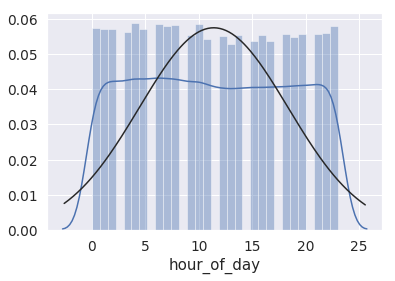

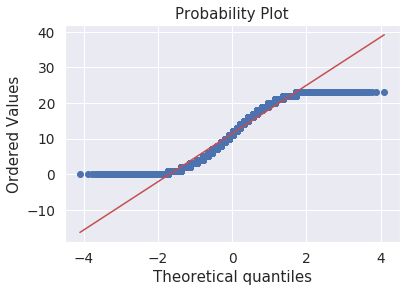

In [132]:
#train['traffic_volume'] = np.sqrt(train['traffic_volume'])
#print(train['traffic_volume'])
#std = MinMaxScaler().fit_transform(train['hour_of_day'][:,np.newaxis]);
sns.distplot(train['hour_of_day'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['hour_of_day'], plot=plt)

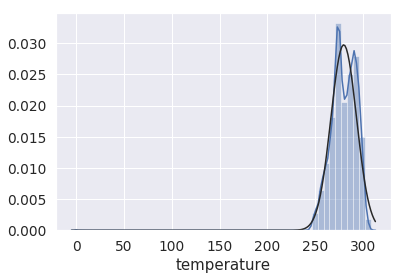

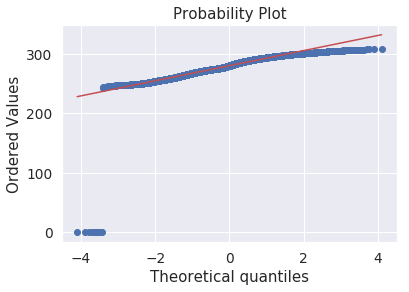

In [133]:
sns.distplot(train['temperature'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['temperature'], plot=plt)

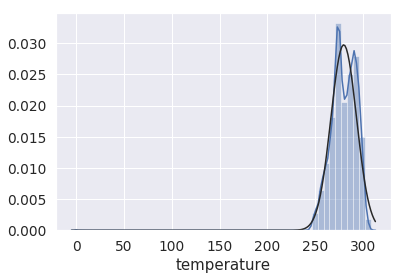

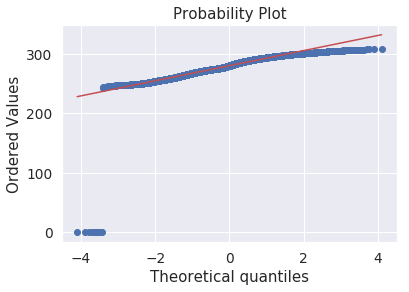

In [134]:
#train['temperature'] = np.power(train['temperature'], 4)
sns.distplot(train['temperature'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['temperature'], plot=plt)

In [135]:
COLUMNS = col_train_num
FEATURES = col_train_num_bias
LABEL = "traffic_volume"

#FEATURES.remove('Price')

# Training set and Prediction set with the features to predict
training_set = train_set[col_train_num]
prediction_set = training_set.traffic_volume

# print(prediction_set)

X_train, X_val, y_train, y_val = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.4)

alg=IsolationForest(max_samples= 256)

alg.fit(X_train)

preds = alg.predict(X_val)

print(preds)
print(y_val)

print("#############################\n#############################")

print(accuracy_score(y_val, preds))

print(roc_auc_score(y_val, preds))

cm = confusion_matrix(y_val, preds)

print(cm)

print("#############################\n#############################")


[1 1 1 ... 1 1 1]
29026    0.403297
31527    0.897115
12935    0.601648
4421     0.038736
12143    0.763187
8843     0.864286
22627    0.057280
11596    0.340247
9327     0.616758
33212    0.340385
13723    0.693681
25687    0.358654
11036    0.189560
30523    0.175962
22909    0.727473
3483     0.337912
5163     0.425275
1940     0.711264
17279    0.278984
7452     0.656593
24363    0.063324
18291    0.056868
31322    0.594643
31       0.398077
31180    0.644780
30922    0.841209
4902     0.154396
8924     0.078846
10741    0.050137
3562     0.876511
           ...   
22346    0.244093
23886    0.437225
237      0.105632
6451     0.299863
29983    0.372665
31122    0.130769
26830    0.658516
28840    0.765522
1506     0.592720
21742    0.137225
12103    0.618132
1049     0.050962
21605    0.751648
25540    0.573489
6072     0.442720
15857    0.318956
5537     0.496016
7438     0.088324
10192    0.501236
8701     0.771291
18055    0.640110
18412    0.630082
2892     0.042033
10177    0

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [ ]:
hello

In [ ]:
train.hist(figsize=(15, 15))
plt.show()

In [ ]:
train['traffic_volume'] = np.sqrt(train['traffic_volume'])
#sns.distplot(train['traffic_volume'], fit=stats.norm);
#fig = plt.figure()
#res = stats.probplot(train['traffic_volume'], plot=plt)

In [ ]:
train['temperature'] = np.sqrt(train['temperature'])
#sns.distplot(train['temperature'], fit=stats.norm);
#fig = plt.figure()
#res = stats.probplot(train['temperature'], plot=plt)

In [ ]:
#train.plot.scatter(x='hour_of_day', y='traffic_volume', s='temperature', ylim=(0,20));
plt.scatter(x=train.hour_of_day, y=train.traffic_volume, s=train.temperature)

In [ ]:
train.plot.kde(figsize=(15, 15))
plt.show()

In [ ]:
scatter_matrix(train, figsize=(20, 20))
plt.show()

In [ ]:
sns.distplot(train['traffic_volume']);

In [ ]:
#saleprice correlation matrix
k = 6 #number of variables for heatmap
cols = corrmat.nlargest(k, 'traffic_volume')['traffic_volume'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(10, 10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(train['traffic_volume'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

In [ ]:
col_train_num = list(cols)
#col_train_num.append("is_holiday")
#col_train_num.append("weather_type")
#col_train_num.append("weather_description")

col_train_num_bias = list(cols)
#col_train_num_bias.append("is_holiday")
#col_train_num_bias.append("weather_type")
#col_train_num_bias.append("weather_description")
col_train_num_bias.remove('traffic_volume')

print(col_train_num_bias)

#test = test[col_train_num_bias]
#train = train[col_train_num]

train = train[col_train_num]
test = test[col_train_num_bias]
test = test.interpolate(method ='linear', limit_direction ='both')
#test = test.interpolate(method ='linear', limit_direction ='both') 
#scatter_matrix(train[col_train_num], figsize=(25, 25))
#plt.show()
#test.isnull().sum().max()

In [ ]:
from scipy import stats
#histogram and normal probability plot
sns.distplot(train['traffic_volume'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['traffic_volume'], plot=plt)

In [ ]:
#train_numerical = train.select_dtypes(exclude=['object'])

for col in col_train_num:
    print(col)
    try:
        plt.figure()
        sns.distplot(train[col], fit=stats.norm);
        fig = plt.figure()
        res = stats.probplot(train[col], plot=plt)
    except TypeError:
        print("No graph for this {} column".format(col))
    #fig = plt.figure()
    #stats.probplot(train[col], plot=plt)

In [ ]:
train['traffic_volume'] = np.sqrt(train['traffic_volume'])
sns.distplot(train['traffic_volume'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['traffic_volume'], plot=plt)

In [ ]:
train['temperature'] = np.sqrt(train['temperature'])
sns.distplot(train['temperature'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['temperature'], plot=plt)

In [ ]:
train['clouds_all'] = np.sqrt(train['clouds_all'])
sns.distplot(train['clouds_all'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['clouds_all'], plot=plt)

In [ ]:
"""
combined_set['wind_speed'] = np.cbrt(combined_set['wind_speed'])
sns.distplot(combined_set['wind_speed'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(combined_set['wind_speed'], plot=plt)
"""

In [ ]:
train['humidity'] = np.sqrt(train['humidity'])
sns.distplot(train['humidity'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['humidity'], plot=plt)

In [ ]:
train['air_pollution_index'] = np.sqrt(train['air_pollution_index'])
sns.distplot(train['air_pollution_index'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['air_pollution_index'], plot=plt)

In [ ]:
"""
train['PLUS_DI'] = np.log(train['PLUS_DI'])
test['PLUS_DI'] = np.log(test['PLUS_DI'])
sns.distplot(train['PLUS_DI'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['PLUS_DI'], plot=plt)
"""

In [ ]:
"""
train.loc[train['WILLR']>0, 'WILLR'] = np.log(train[train['WILLR']>0]['WILLR'])
sns.distplot(train['WILLR'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['WILLR'], plot=plt)
"""

In [ ]:
scatter_matrix(train, figsize=(20, 20), diagonal="kde")
plt.show()

In [ ]:
for col in col_train_num:
    print(col)
    try:
        cm = plt.cm.get_cmap('RdYlBu')
        data = pd.concat([train['traffic_volume'], train[col]], axis=1)
        data.plot.scatter(x=col, y='traffic_volume', ylim=(0,20));
    except ValueError:
        print("No graph for this {} column".format(col))
        raise

In [ ]:
corrmat_next = train.corr()
cols_next = corrmat_next.index
f, ax = plt.subplots(figsize=(5, 5))
hm = sns.heatmap(corrmat_next, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols_next.values, xticklabels=cols_next.values)
plt.show()

In [ ]:
combined_set = pd.concat([train, test], axis=0, ignore_index=True)
#combined_set = pd.get_dummies(combined_set)
display(combined_set.head())

In [ ]:
print(combined_set.shape)

train = combined_set[:24950]
test = combined_set[24951:]
test = test.drop("traffic_volume",axis = 1)

col_train = list(train.columns)
col_train_bis = list(train.columns)
col_train_bis.remove("traffic_volume")

mat_train = np.matrix(train)
mat_test  = np.matrix(test)
mat_new = np.matrix(train.drop('traffic_volume',axis = 1))

mat_y = np.array(train.traffic_volume).reshape((24950,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

# trimed_test.to_csv("output_final_3.csv")
train_set = pd.DataFrame(prepro.transform(train),columns = col_train)

# test = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

test_set  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

display(train_set.head())

In [ ]:
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "traffic_volume"

#FEATURES.remove('Price')

# Training set and Prediction set with the features to predict
training_set = train_set[col_train]
prediction_set = training_set.traffic_volume

# print(prediction_set)

X_train, X_val, y_train, y_val = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.4)

train_set_tensor = torch.utils.data.TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values))
val_set = torch.utils.data.TensorDataset(torch.FloatTensor(X_val.values), torch.FloatTensor(y_val.values))

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set_tensor,batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size)
val_test_loader = torch.utils.data.DataLoader(val_set,batch_size=1, shuffle=False)

In [ ]:
"""
train_numerical = train.select_dtypes(exclude=['object'])
train_numerical.fillna(0,inplace = True)
train_categoric = train.select_dtypes(include=['object'])
train_categoric.fillna('NONE',inplace = True)
train_new = train_numerical.merge(train_categoric, left_index = True, right_index = True)

test_numerical = test.select_dtypes(exclude=['object'])
test_numerical.fillna(0,inplace = True)
test_categoric = test.select_dtypes(include=['object'])
test_categoric.fillna('NONE',inplace = True)
test_new = test_numerical.merge(test_categoric, left_index = True, right_index = True) 

train.dtypes
"""

In [ ]:
"""
# Removie the outliers
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train_numerical)
y_noano = clf.predict(train_numerical)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train_numerical = train_numerical.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_numerical.reset_index(drop = True, inplace = True)

train_categoric = train_categoric.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_categoric.reset_index(drop = True, inplace = True)

train_new = train_new.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_new.reset_index(drop = True, inplace = True)
display(train_new.head())
"""

In [ ]:
"""
#col_train = list(train_new.columns)
col_train_num = list(train_numerical.columns)
col_train_num_bis = list(train_numerical.columns)

col_train_cat = list(train_categoric.columns)

col_train_num_bis.remove('Price')

mat_train = np.matrix(train_numerical)
mat_test  = np.matrix(test_numerical)
mat_new = np.matrix(train_numerical.drop('Price',axis = 1))
mat_y = np.array(train_new.Price)

print(mat_y.shape)

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y.reshape(5417,1))

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train_num_scale = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)
test_num_scale  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_num_bis)

def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

train_new[col_train_num] = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)
test_new[col_train_num_bis]  = test_num_scale

prediction_set = train_new.Price
print(prediction_set.shape)
combined = train_new.drop('Price',axis = 1).append(test_new)
combined.reset_index(inplace=True)
print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, col_train_cat)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

train_new = combined[:5417]
test_new = combined[5417:]
"""

In [ ]:
"""
# Train and Test 
X_train, X_val, y_train, y_val = train_test_split(train_new, prediction_set, test_size=0.33, random_state=42)
train_set_tensor = torch.utils.data.TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values))
val_set = torch.utils.data.TensorDataset(torch.FloatTensor(X_val.values), torch.FloatTensor(y_val.values))

batch_size = 1
train_loader = torch.utils.data.DataLoader(train_set_tensor,batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size)
"""

In [ ]:
# Hyperparameters
# batch_no = len(X_train) // batch_size  #batches
# cols=X_train.shape[1] #Number of columns in input matrix

# Sequence Length
#sequence_length = 6  # of words in a sequence 892110
# Batch Size
# batch_size = 128
# train_loader = batch_data(int_text, sequence_length, batch_size)
# Number of Epochs
num_epochs = 2000
# Learning Rate
learning_rate = 0.002
# Model parameters
# Input size
input_size = X_train.shape[1]
# Output size
output_size = 1
# Embedding Dimension
#embedding_dim = 128
# Hidden Dimension
hidden_dim = 128
# Number of RNN Layers
n_layers = 2

# Show stats for every n number of batches
show_every_n_batches = 50

In [ ]:
import torch.nn as nn

class DNNClassifier(nn.Module):
    """
    This is the simple DNN model we will be using to perform Sentiment Analysis.
    """

    def __init__(self, hidden_dim, input_size, output_size, dropout=0.5):
        """
        Initialize the model by settingg up the various layers.
        """
        super(DNNClassifier, self).__init__()

        self.sig = nn.Sigmoid()        
        # self.word_dict = None
        
        self.fc1 = nn.Linear(input_size, hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        #self.fc3 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc4 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(p=0.5)
        self.init_weights()
        
    def init_weights(m):
        initrange = 0.08
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            # get the number of the inputs
            n = m.in_features
            y = 1.0/np.sqrt(n)
            m.weight.data.normal_(0.0, y)
            m.bias.data.fill_(0)
        
    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        out = self.out(x)
        return out

In [ ]:
from torch.autograd import Variable

def forward_back_prop(rnn, optimizer, criterion, inputs, labels, clip=9):

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    hidden = {}
    # hidden = tuple([each.data for each in hidden_dim])
    
    rnn.zero_grad()
    optimizer.zero_grad()
    #print(inputs)
    try:
        # get the output from the model
        # output, hidden = rnn(inputs, hidden)
        output = rnn.forward(inputs)
        #output = rnn(inputs.unsqueeze(0))
        output = output.squeeze()
        #print(output)
    except RuntimeError:
        raise
    #print(labels)
    loss = criterion(output, labels)
    loss.backward()
    
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    # nn.utils.clip_grad_norm_(rnn.parameters(),  clip)
   
    optimizer.step()

    return loss.item()

In [ ]:
def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    batch_losses = []
    val_batch_losses = []
    valid_loss_min = np.Inf
    
    rnn.train()
    
    previousLoss = np.Inf
    minLoss = np.Inf

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # initialize hidden state
        # hidden = rnn.init_hidden(batch_size)
        # print("epoch ",epoch_i)
        rnn.train()
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            # batch_last = batch_i
            # n_batches = len(train_loader.dataset) // batch_size
            loss = forward_back_prop(rnn, optimizer, criterion, inputs, labels, clip=5)
            #print(loss)
            # record loss
            batch_losses.append(loss)
            
        rnn.eval()
        for batch_i, (inputs, labels) in enumerate(val_loader, 1):
            # batch_last = batch_i
            # n_batches = len(val_loader.dataset) // batch_size
            if(train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            # if(batch_i > n_batches):
                # break
            try:
                output = rnn.forward(inputs)
                output = output.squeeze()
            except RuntimeError:
                raise
            # print(labels)
            loss = criterion(output, labels)

            val_batch_losses.append(loss.item())

        # printing loss stats
        if epoch_i%show_every_n_batches == 0:
            average_loss = np.average(batch_losses)
            val_average_loss = np.average(val_batch_losses)
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch_i, average_loss, val_average_loss))

            ## TODO: save the model if validation loss has decreased
            # save model if validation loss has decreased
            if val_average_loss < valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                val_average_loss))
                with open('save/trained_rnn_new', 'wb') as pickle_file:
                    torch.save(rnn, pickle_file)
                valid_loss_min = val_average_loss

            batch_losses = []
            val_batch_losses = []
            
    return rnn

In [ ]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

In [ ]:
# create model and move to gpu if available
# rnn = RNN(input_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.25)
# rnn.apply(weight_init)
#rnn = LSTMClassifier(embedding_dim, hidden_dim, input_size, n_layers, output_size)
rnn = DNNClassifier(hidden_dim, input_size, output_size)

#rnn = torch.load("save/trained_rnn_new")

if train_on_gpu:
    rnn.cuda()

decay_rate = learning_rate / num_epochs

# print(decay_rate)
# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9, weight_decay=decay_rate)

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
#rnn = torch.load("trained_rnn_new")

# training the model
trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
# helper.save_model('./save/trained_rnn', trained_rnn)
print('Model Trained and Saved')

In [ ]:
def predict(model, inputs):

    if(train_on_gpu):
        inputs = inputs.cuda()
    
    try:
        output = model.forward(inputs)
        output = output.squeeze()
        #print(output)
    except RuntimeError:
        raise
    
    # prediction = np.array(output).argmax(0)
    # p = F.softmax(output, dim=1).data
    # p = F.sigmoid(output)
    # p = F.logsigmoid(output)
    p = output.cpu().detach().numpy().flatten()
    #print(p[0])
    # prediction = np.argmax(p)
    # print(prediction)
    return p[0]

In [ ]:
model_rnn = torch.load("save/trained_rnn_new")
model_rnn.eval()
display(X_train.head())

In [ ]:
display(test_set.head())

In [ ]:
Val_outputs = []
Val_tagrets = []

for batch_i, (inputs, labels) in enumerate(val_test_loader, 1):
    # n_batches = len(val_loader.dataset) // batch_size
    try:
        labels = labels.cpu().detach().numpy().flatten()
        valoutput = predict(model_rnn, torch.FloatTensor(inputs))
        Val_outputs.append(valoutput)
        Val_tagrets.append(labels[0])
    except RuntimeError:
        raise

print(Val_outputs[:10])
print(Val_tagrets[:10])

r2_score(Val_tagrets, Val_outputs)

In [ ]:
Val_outputs = []
print(train[:500].shape)

pred_training_set = train_set[col_train][:500]
pred_training_set = pred_training_set.drop('traffic_volume',axis = 1)

for row in pred_training_set.values:
    valoutput = predict(model_rnn, torch.FloatTensor(row))
    Val_outputs.append(valoutput)

print(Val_outputs[:10])
print(y_val.values[:10])

s_out = pd.Series(prepro_y.inverse_transform(np.array(Val_outputs).reshape(500,1)).squeeze())
t_out =  np.exp(s_out)
print(t_out.values[:20])
print(train_csv['traffic_volume'].values[:20])
r2_score(train_csv['traffic_volume'].values[:500], t_out.values)

In [ ]:
Test_outputs = []
for row in test_set.values:
    testoutput = predict(model_rnn, torch.FloatTensor(row))
    Test_outputs.append(testoutput)

print(Test_outputs[:30])
print(len(Test_outputs))

In [ ]:
"""
test_input = torch.randn(3, 5, requires_grad=True)
test_target = torch.randn(3, 5)
X = Variable(torch.FloatTensor(X_train.values)) 
print(X)
pred = predict(model_rnn, X)
print(pred[:30])
print(pred.shape)
# pred= result
print(y_val.values[:30])
r2_score(y_train.values, pred)

loss = nn.L1Loss()
output_loss = loss(torch.FloatTensor(y_train.values),torch.FloatTensor(pred))
print(1 - output_loss)
"""


In [ ]:
"""
test_X = Variable(torch.FloatTensor(test_set.values))
print(test_X)
test_pred = predict(model_rnn, test_X)
print(test_pred)
print(len(test_pred))
# print(np.array(test_p).reshape(9614,1))
"""

In [ ]:
a = np.array([2,4,8,10,12,18, 100, 200, 400])
log_a = np.log(a)
exp_a = np.exp(log_a)
print(a)
print(log_a)
print(exp_a)

In [ ]:
s_out = pd.Series(prepro_y.inverse_transform(np.array(Test_outputs).reshape(10179,1)).squeeze())
t_out =  np.power(s_out, 3)
predictions = pd.DataFrame(test_csv["date_time"].values, columns = ["date_time"])
# predictions = pd.DataFrame(np.array(test_pred).reshape(8037,1), columns = ["FORECLOSURE"])
# predictions["FORECLOSURE"] = predictions["FORECLOSURE"]
# predictions['SalePrice'] = predictions['SalePrice']
# predictions['FORECLOSURE'] = predictions['FORECLOSURE'].apply(lambda x: 0 if x < 0.01 else 1)
# predictions['FORECLOSURE'] = predictions['FORECLOSURE'].apply(lambda x: 1 if x > 0 else x)
# predictions = predictions.round(2)
# predictions["ID"] = test_csv["ID"]
predictions["traffic_volume"] = t_out
display(predictions.head())

In [ ]:
predictions.to_csv("submission_3.csv", index=False)

In [ ]:
# import the modules we'll need
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename="submission_1.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(predictions)